# Time Series Data Analysis
## FRED
* Board of Governors of the Federal Reserve System (US), South Korea / U.S. Foreign Exchange Rate [DEXKOUS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DEXKOUS, July 14, 2021.

### South Korea / U.S. Foreign Exchange Rate from 2009-04-10 to 2021-07-09

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller

## 1. Data Preprocessing

In [3]:
df = pd.read_csv('Data/DEXKOUS.csv',
                parse_dates=['DATE'], index_col='DATE')

In [7]:
df.head()

,DEXKOUS
DATE,
2009-04-10,1328.0000
2009-04-13,1328.9000
2009-04-14,1319.5000
2009-04-15,1333.0000
2009-04-16,1331.0000


In [8]:
# change column name to simple one 
df.columns=['KOUS']

In [9]:
# Dtype should be float, so preprocessing is needed
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3196 entries, 2009-04-10 to 2021-07-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   KOUS    3196 non-null   object
dtypes: object(1)
memory usage: 49.9+ KB


In [14]:
df['KOUS'].replace('.', '', inplace=True)
df['KOUS'] = pd.to_numeric(df['KOUS'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3196 entries, 2009-04-10 to 2021-07-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   KOUS    3066 non-null   float64
dtypes: float64(1)
memory usage: 49.9 KB


In [16]:
# to fill any null value by using 'ffill' method
df['KOUS'].fillna(method='ffill', inplace=True)

Text(0.5, 1.0, 'South Korea / U.S. Foreign Exchange Rate')

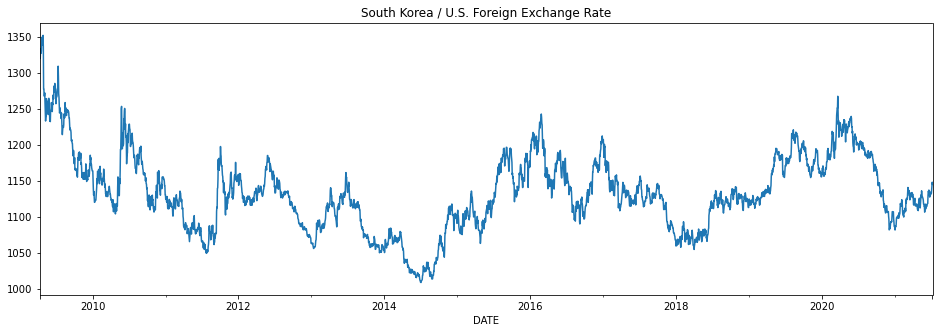

In [25]:
df['KOUS'].plot(figsize=(16,5))
plt.title('South Korea / U.S. Foreign Exchange Rate')

## 2. ACF, PACF 분석을 통한 인사이트 도출
* 외부 요인이 얼마나 지속되었는가?

In [22]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [26]:
# 보기쉽게 '주단위'로 변경 후 그 주의 마지막 value만 취급
df_w = df.resample('W-Fri').last()

In [39]:
df_2017 = df_w[df_w.index.year == 2017]

In [40]:
df_2020 = df_w[df_w.index.year == 2020]

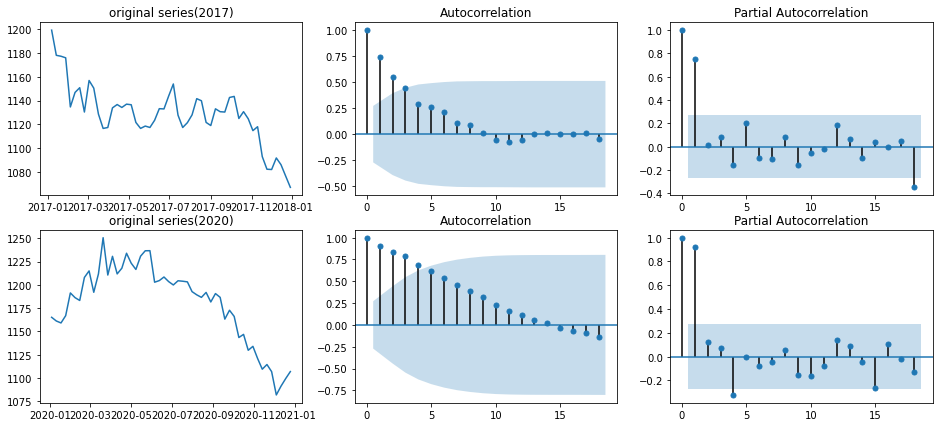

In [41]:
# 첫번째줄 : 2017년 데이터의 원계열, ACF, PACF
# 두번째줄 : 2020년 데이터의 원계열, ACF, PACF
figure, axes = plt.subplots(2, 3, figsize=(16,7))
axes[0,0].plot(df_2017)
axes[0,0].set_title('original series(2017)')
axes[1,0].plot(df_2020)
axes[1,0].set_title('original series(2020)')
plot_acf(df_2017, ax=axes[0,1])
plot_acf(df_2020, ax=axes[1,1])
plot_pacf(df_2017, ax=axes[0,2])
plot_pacf(df_2020, ax=axes[1,2])
plt.show()

- Autocorrelation을 보면 2017년에 비해 2020년은 외부 충격이 오래 지속되었다는 것을 알수있다
- 2017년에는 외부 충격이 다음기에 0.75 남아있지만, 2020년에는 0.9이상 남아있다
    - 2020년의 Persistency가 증가하고 있다
- 2017, 2020년 둘다 AR모형을 따라간다
    - ACF는 서서히 줄어들고, PACF는 처음 두개만 튀어있기 때문이다

## 3. ARIMA 모델 적용
### 2019년의 exchange rates

In [44]:
from statsmodels.tsa.arima_model import ARIMA

In [258]:
df_2019 = df[(df.index > '2019-01-01') & (df.index < '2020-01-01')]

### ARIMA(p,k,q)의 k 결정

In [259]:
# p-value가 0.3635로 높기 때문에 stationary하지 않아 차분이 필요함
adfuller(df_2019.KOUS)

(-1.834289925068011,
 0.36357542996557135,
 2,
 257,
 {'1%': -3.4560535712549925,
  '5%': -2.8728527662442334,
  '10%': -2.5727985212493754},
 1453.3457437081727)

In [261]:
# p-value가 7.239e-19로 매우 낮기 때문에 사용가능 함
adfuller(df_2019.KOUS.diff().dropna())

(-10.572632524492832,
 7.239046680336767e-19,
 1,
 257,
 {'1%': -3.4560535712549925,
  '5%': -2.8728527662442334,
  '10%': -2.5727985212493754},
 1446.168602565303)

- k = 1로 결정함
    - 1차분이 제일 안정적

### ARIMA(p,k,q)의 p, q 결정

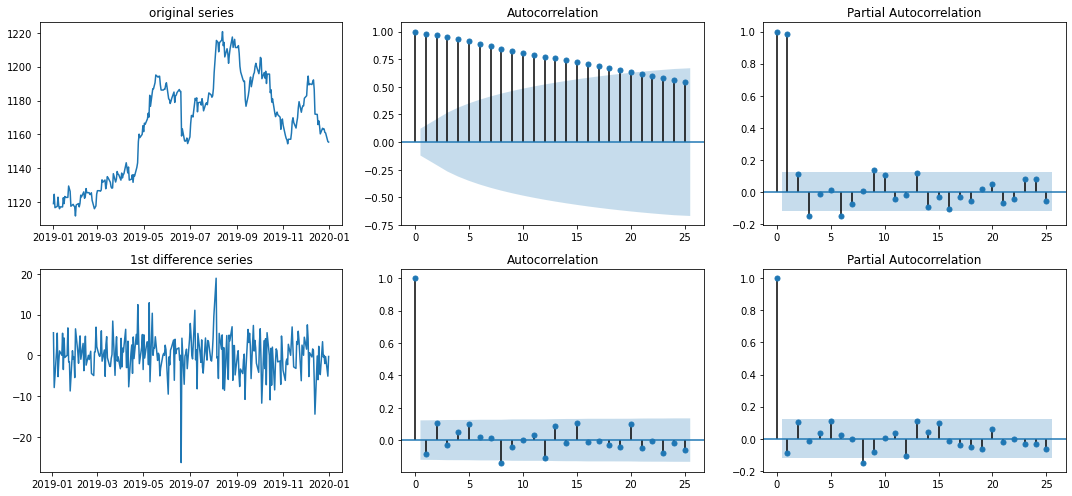

In [262]:
# 첫번째줄 : 0 차분
# 두번째줄 : 1 차분 후
figure, axes = plt.subplots(2,3, figsize=(15,7))
axes[0,0].plot(df_2019.KOUS)
axes[0,0].set_title('original series')
axes[1,0].plot(df_2019.KOUS.diff())
axes[1,0].set_title('1st difference series')
plot_acf(df_2019.KOUS, axes[0,1])
plot_pacf(df_2019.KOUS, axes[0,2])
plot_acf(df_2019.KOUS.diff().dropna(), axes[1,1])
plot_pacf(df_2019.KOUS.diff().dropna(), axes[1,2])
plt.tight_layout()
plt.show()

### p와 q 유효후보

- AR차수: 3차 ~ 1차
- MA차수: 2차 ~ 0차


## 4. ARIMA 예측

In [263]:
# ARIMA(3,1,2)
model = ARIMA(df_2019.KOUS, order=(3,1,2), freq='B')
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -768.706
Method:                       css-mle   S.D. of innovations              4.677
Date:                Thu, 15 Jul 2021   AIC                           1549.412
Time:                        21:32:51   BIC                           1570.753
Sample:                    01-03-2019   HQIC                          1557.992
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.2878      0.064     -4.504      0.000      -0.413      -0.163
ar.L2.D.KOUS    -0.9557      0.030    -31.909      0.000      -1.014      -0.897
ar.L3.D.KOUS    -0.0885      0.064     -1.38

In [264]:
# ARIMA(2,1,2) 
model = ARIMA(df_2019.KOUS, order=(2,1,2), freq='B')
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -769.208
Method:                       css-mle   S.D. of innovations              4.715
Date:                Thu, 15 Jul 2021   AIC                           1548.416
Time:                        21:33:43   BIC                           1566.200
Sample:                    01-03-2019   HQIC                          1555.566
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -1.2447      0.243     -5.123      0.000      -1.721      -0.768
ar.L2.D.KOUS    -0.7340      0.257     -2.851      0.004      -1.239      -0.229
ma.L1.D.KOUS     1.1778      0.245      4.80

In [267]:
# ARIMA(1,1,2)
model = ARIMA(df_2019.KOUS, order=(1,1,2), freq='B')
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -769.744
Method:                       css-mle   S.D. of innovations              4.726
Date:                Thu, 15 Jul 2021   AIC                           1547.487
Time:                        21:35:10   BIC                           1561.714
Sample:                    01-03-2019   HQIC                          1553.207
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.3592      0.370     -0.971      0.332      -1.084       0.366
ma.L1.D.KOUS     0.2847      0.370      0.769      0.442      -0.440       1.010
ma.L2.D.KOUS     0.0823      0.071      1.15

In [268]:
# ARIMA(3,1,1)
model = ARIMA(df_2019.KOUS, order=(3,1,1), freq='B')
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -767.995
Method:                       css-mle   S.D. of innovations              4.690
Date:                Thu, 15 Jul 2021   AIC                           1545.990
Time:                        21:35:38   BIC                           1563.774
Sample:                    01-03-2019   HQIC                          1553.140
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -1.0501      0.065    -16.076      0.000      -1.178      -0.922
ar.L2.D.KOUS     0.0314      0.090      0.350      0.727      -0.145       0.207
ar.L3.D.KOUS     0.1255      0.063      1.98

In [270]:
# ARIMA(2,1,1)
model = ARIMA(df_2020.KOUS, order=(2,1,1), freq='B')
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -769.765
Method:                       css-mle   S.D. of innovations              4.726
Date:                Thu, 15 Jul 2021   AIC                           1547.530
Time:                        21:36:00   BIC                           1561.757
Sample:                    01-03-2019   HQIC                          1553.250
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.2113      0.530     -0.399      0.690      -1.250       0.827
ar.L2.D.KOUS     0.0924      0.082      1.134      0.257      -0.067       0.252
ma.L1.D.KOUS     0.1356      0.532      0.25

In [272]:
# ARIMA(1,1,1)
model = ARIMA(df_2020.KOUS, order=(1,1,1), freq='B')
model_fit = model.fit(trend='nc')
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.KOUS   No. Observations:                  259
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -770.298
Method:                       css-mle   S.D. of innovations              4.736
Date:                Thu, 15 Jul 2021   AIC                           1546.597
Time:                        21:36:21   BIC                           1557.267
Sample:                    01-03-2019   HQIC                          1550.887
                         - 12-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.D.KOUS    -0.5804      0.235     -2.469      0.014      -1.041      -0.120
ma.L1.D.KOUS     0.4829      0.249      1.939      0.053      -0.005       0.971
                                    Roots   

- 6개의 모델들 중, p-value <= 0.05를 만족시키면서 작은 AIC value를 주는 모델은 ARIMA(2,1,2)이다

### 5. TRAIN, TEST SET evaluation

In [278]:
# Training set, Test set을 나누어서 학습과 평가
# exchange rate는 롱텀으로 예측할 수 없기에 이전 30일로 그 다음주 5일을 예측할 수 있는가를 테스트
train = df_2019.iloc[0:30]
test = df_2019.iloc[30:35]
print(train.shape)
print(test.shape)

(30, 1)
(5, 1)


In [275]:
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(trend='nc')
fc, se, conf = model_fit.forecast(5, alpha=0.05)

/Users/seonil/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/seonil/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


In [276]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

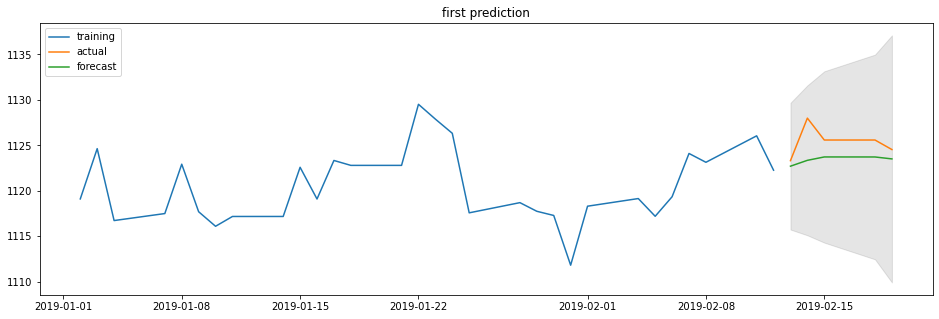

In [284]:
# plot
plt.figure(figsize=(16,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(test.index, lower_series, upper_series, color='black', alpha=0.1)
plt.legend(loc='upper left')
plt.title('first prediction')
plt.show()

In [285]:
# Training set, Test set을 나누어서 학습과 평가
# exchange rate는 롱텀으로 예측할 수 없기에 이전 30일로 그 다음주 5일을 예측할 수 있는가를 테스트
train = df_2019.iloc[40:70]
test = df_2019.iloc[70:75]
print(train.shape)
print(test.shape)

(30, 1)
(5, 1)


In [286]:
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(trend='nc')
fc, se, conf = model_fit.forecast(5, alpha=0.05)

/Users/seonil/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
/Users/seonil/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


In [287]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

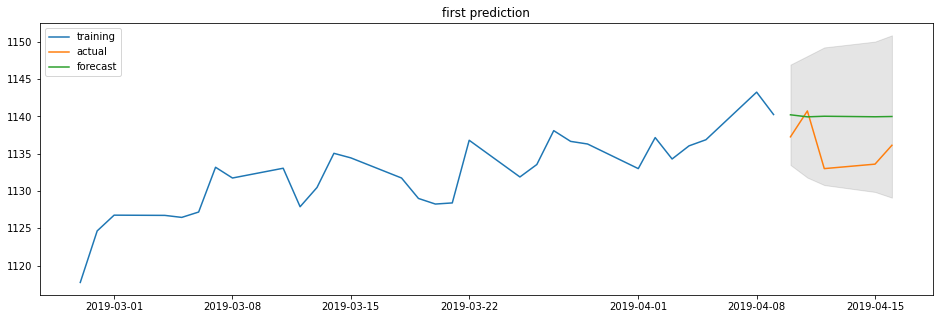

In [288]:
# plot
plt.figure(figsize=(16,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(test.index, lower_series, upper_series, color='black', alpha=0.1)
plt.legend(loc='upper left')
plt.title('first prediction')
plt.show()